In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./dataset', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./dataset', train=False, transform=transform, download=True)

subset_indices = []
for label in range(10):
    label_indices = np.where(np.array(train_dataset.targets) == label)[0]
    sampled_indices = np.random.choice(label_indices, size=600, replace=False)
    subset_indices.extend(sampled_indices)

# Create the subset

train_dataset_subset = Subset(train_dataset, subset_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
# Define the VGG11 model
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [5]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

cuda


In [6]:
def train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, num_epochs=20, device=device):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # lists to store metrics
    test_accuracies = []
    train_accuracies = []
    test_losses = []
    train_losses = []

    # Training and evaluation loop
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        running_train_acc = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_train_acc +=  (preds == labels).float().mean().item()
            
        # Store average training loss and accuracy
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(running_train_acc / len(train_loader))
        
        # Evaluation phase
        model.eval()
        running_test_loss = 0.0
        running_test_acc = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_test_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                running_test_acc += (preds == labels).float().mean().item()
        
        # Store average test loss and accuracy
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(running_test_acc / len(test_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")
            
    return test_accuracies, train_accuracies, test_losses, train_losses

def evaluate_accuracy(dataloader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

### 1.2 Training inspection

Epoch [1/20], Train Loss: 0.5696, Train Acc: 0.8203, Test Loss: 0.1321, Test Acc: 0.9591
Epoch [2/20], Train Loss: 0.1114, Train Acc: 0.9660, Test Loss: 0.3656, Test Acc: 0.9042
Epoch [3/20], Train Loss: 0.0734, Train Acc: 0.9782, Test Loss: 0.1265, Test Acc: 0.9681
Epoch [4/20], Train Loss: 0.0449, Train Acc: 0.9880, Test Loss: 0.1323, Test Acc: 0.9609
Epoch [5/20], Train Loss: 0.0363, Train Acc: 0.9874, Test Loss: 0.0693, Test Acc: 0.9802
Epoch [6/20], Train Loss: 0.0192, Train Acc: 0.9945, Test Loss: 0.0639, Test Acc: 0.9817
Epoch [7/20], Train Loss: 0.0148, Train Acc: 0.9955, Test Loss: 0.0875, Test Acc: 0.9771
Epoch [8/20], Train Loss: 0.0206, Train Acc: 0.9932, Test Loss: 0.1191, Test Acc: 0.9700
Epoch [9/20], Train Loss: 0.0204, Train Acc: 0.9938, Test Loss: 0.0809, Test Acc: 0.9806
Epoch [10/20], Train Loss: 0.0193, Train Acc: 0.9934, Test Loss: 0.0561, Test Acc: 0.9856
Epoch [11/20], Train Loss: 0.0135, Train Acc: 0.9961, Test Loss: 0.0632, Test Acc: 0.9848
Epoch [12/20], Trai

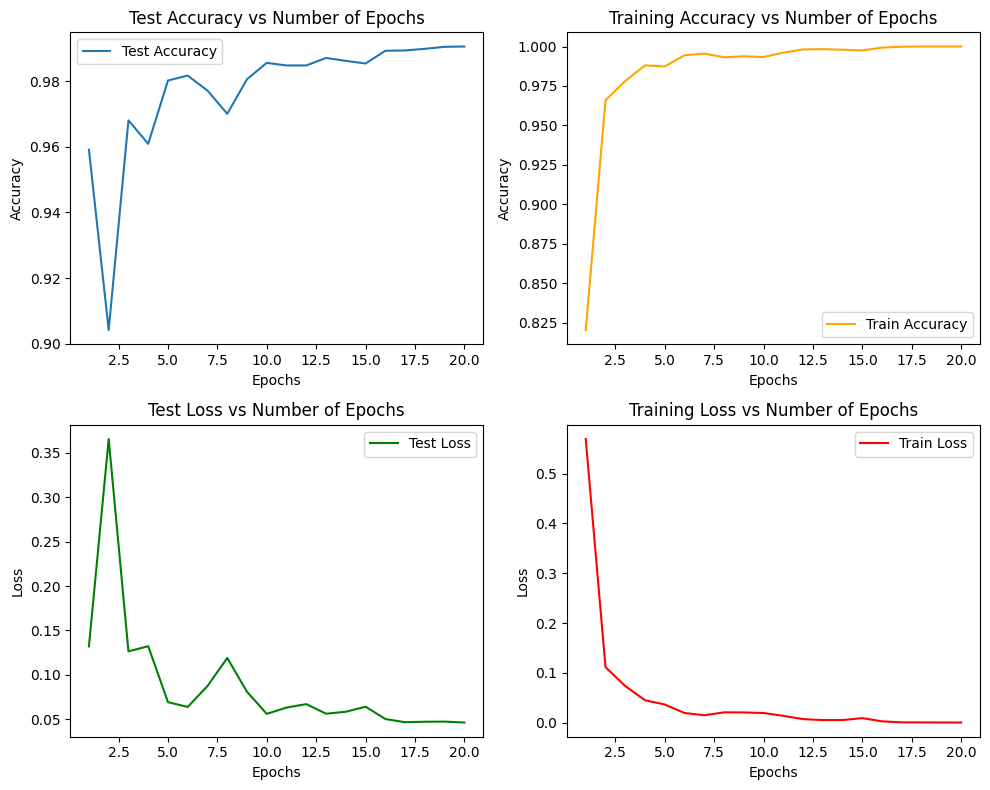

In [7]:
num_epochs = 20
test_accuracies, train_accuracies, test_losses, train_losses = train_and_evaluate(model, criterion=criterion, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs)

epochs = range(1, num_epochs+1)

# Plot test accuracy vs number of epochs
plt.figure(figsize=(10, 8))

# (a) Test Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Number of Epochs')
plt.legend()

# (b) Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Number of Epochs')
plt.legend()

# (c) Test Loss
plt.subplot(2, 2, 3)
plt.plot(epochs, test_losses, label='Test Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss vs Number of Epochs')
plt.legend()

# (d) Training Loss
plt.subplot(2, 2, 4)
plt.plot(epochs, train_losses, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Number of Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## 1.3 Test model's Generalizability

In [8]:
def show_transformed_images(dataset, num_images=5):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.squeeze(), cmap="gray") 
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()
    
# Define transforms for horizontal and vertical flips
horizontal_flip_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor()
])

vertical_flip_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor()
])

h_flip_test_dataset = datasets.MNIST(root='./dataset', train=False, transform=horizontal_flip_transform, download=True)
h_flip_test_loader = DataLoader(h_flip_test_dataset, batch_size=64, shuffle=False)

v_flip_test_dataset = datasets.MNIST(root='./dataset', train=False, transform=vertical_flip_transform, download=True)
v_flip_test_loader = DataLoader(v_flip_test_dataset, batch_size=64, shuffle=False)

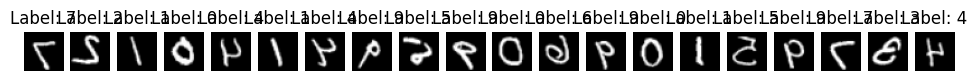

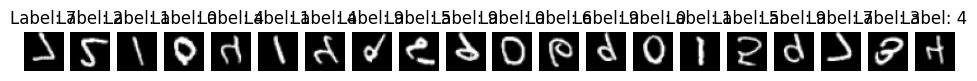

In [9]:
show_transformed_images(h_flip_test_dataset, 20)
show_transformed_images(v_flip_test_dataset, 20)

#### Horizontal and Vertical flip accuracy

In [10]:
# Horizontal flip accuracy
horizontal_flip_accuracy = evaluate_accuracy(h_flip_test_loader, model)
print(f'Horizontal Flip Test Accuracy: {horizontal_flip_accuracy:.4f}%')

# Vertical flip accuracy
vertical_flip_accuracy = evaluate_accuracy(v_flip_test_loader, model)
print(f'Vertical Flip Test Accuracy: {vertical_flip_accuracy:.4f}%')

Horizontal Flip Test Accuracy: 42.1500%
Vertical Flip Test Accuracy: 39.5700%


#### Gaussian noise transformation

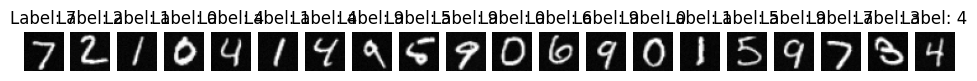

Gaussian Noise (variance=0.01) Test Accuracy: 99.0700%


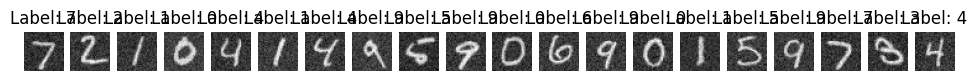

Gaussian Noise (variance=0.1) Test Accuracy: 98.1800%


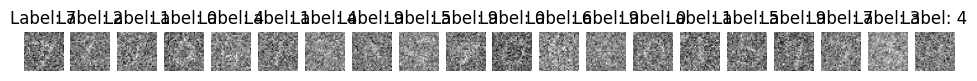

Gaussian Noise (variance=1.0) Test Accuracy: 9.8400%


In [11]:
# Define transforms for Gaussian noise with different variances
noise_variances = [0.01, 0.1, 1.0]
noisy_accuracies = []

for var in noise_variances:
    noise_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + var * torch.randn_like(x))
    ])
    
    noise_test_dataset = datasets.MNIST(root='./dataset', train=False, transform=noise_transform, download=False)
    show_transformed_images(noise_test_dataset, 20)
    noise_test_loader = DataLoader(noise_test_dataset, batch_size=64, shuffle=False)
    
    noisy_accuracy = evaluate_accuracy(noise_test_loader, model)
    noisy_accuracies.append(noisy_accuracy)
    print(f'Gaussian Noise (variance={var}) Test Accuracy: {noisy_accuracy:.4f}%')

## 1.4 Retrain on augmented data 

In [12]:
data_augmentation_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),          # Random rotation
    transforms.RandomHorizontalFlip(p=0.5), # Random horizontal flip
    transforms.ToTensor()
])


train_dataset_augmented = datasets.MNIST(root='./dataset', train=True, transform=data_augmentation_transform, download=False)

subset_indices = []
for label in range(10):
    label_indices = np.where(np.array(train_dataset_augmented.targets) == label)[0]
    sampled_indices = np.random.choice(label_indices, size=600, replace=False)
    subset_indices.extend(sampled_indices)

# Create the subset of training set
train_dataset_augmented_subset = Subset(train_dataset_augmented, subset_indices)

train_loader_augmented = DataLoader(train_dataset_augmented_subset, batch_size=64, shuffle=True)

# Retrain the model with augmented data
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader_augmented:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader_augmented):.4f}')

# Evaluate accuracy on test set after retraining
test_accuracy = evaluate_accuracy(test_loader, model)
print(f'Test Accuracy after Data Augmentation: {test_accuracy:.2f}%')

Epoch [1/20], Loss: 0.4193
Epoch [2/20], Loss: 0.1466
Epoch [3/20], Loss: 0.1110
Epoch [4/20], Loss: 0.0916
Epoch [5/20], Loss: 0.0949
Epoch [6/20], Loss: 0.0775
Epoch [7/20], Loss: 0.0702
Epoch [8/20], Loss: 0.0772
Epoch [9/20], Loss: 0.0596
Epoch [10/20], Loss: 0.0477
Epoch [11/20], Loss: 0.0495
Epoch [12/20], Loss: 0.0509
Epoch [13/20], Loss: 0.0382
Epoch [14/20], Loss: 0.0415
Epoch [15/20], Loss: 0.0330
Epoch [16/20], Loss: 0.0207
Epoch [17/20], Loss: 0.0283
Epoch [18/20], Loss: 0.0335
Epoch [19/20], Loss: 0.0319
Epoch [20/20], Loss: 0.0256
Test Accuracy after Data Augmentation: 97.59%


## Exerice 1.5 Train model with AdaDelta and Adam optimizers

AdaDelta
Epoch [1/20], Train Loss: 2.1467, Train Acc: 0.1796, Test Loss: 3.4499, Test Acc: 0.1033
Epoch [2/20], Train Loss: 1.5600, Train Acc: 0.3589, Test Loss: 1.3155, Test Acc: 0.4811
Epoch [3/20], Train Loss: 0.9936, Train Acc: 0.6423, Test Loss: 1.3944, Test Acc: 0.6894
Epoch [4/20], Train Loss: 0.4701, Train Acc: 0.8712, Test Loss: 0.6011, Test Acc: 0.8425
Epoch [5/20], Train Loss: 0.2279, Train Acc: 0.9417, Test Loss: 0.2467, Test Acc: 0.9335
Epoch [6/20], Train Loss: 0.1899, Train Acc: 0.9530, Test Loss: 0.1354, Test Acc: 0.9640
Epoch [7/20], Train Loss: 0.1282, Train Acc: 0.9656, Test Loss: 0.1215, Test Acc: 0.9695
Epoch [8/20], Train Loss: 0.1015, Train Acc: 0.9722, Test Loss: 0.1798, Test Acc: 0.9629
Epoch [9/20], Train Loss: 0.0932, Train Acc: 0.9801, Test Loss: 0.1253, Test Acc: 0.9696
Epoch [10/20], Train Loss: 0.0927, Train Acc: 0.9777, Test Loss: 0.0843, Test Acc: 0.9805
Epoch [11/20], Train Loss: 0.0664, Train Acc: 0.9850, Test Loss: 0.2960, Test Acc: 0.9482
Epoch [12/

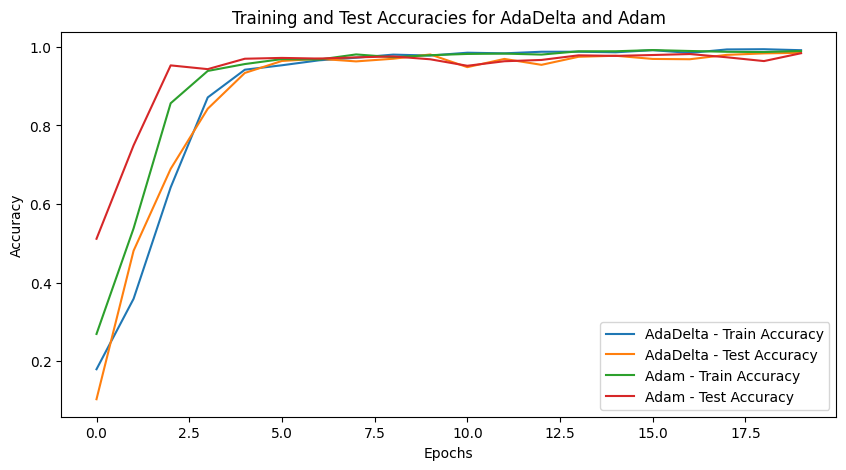

In [13]:
train_accuracies_adadelta, test_accuracies_adadelta = [], []
train_accuracies_adam, test_accuracies_adam = [], []

# Training with AdaDelta optimizer
model_adadelta = VGG11().to(device)
optimizer_adadelta = optim.Adadelta(model_adadelta.parameters())

print("AdaDelta")
test_accuracies_adadelta, train_accuracies_adadelta, _, _ = train_and_evaluate(model_adadelta, criterion=criterion, optimizer=optimizer_adadelta, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs)

# Training with Adam optimizer
model_adam = VGG11().to(device)
optimizer_adam = optim.Adam(model_adam.parameters())

print("Adam")
test_accuracies_adam, train_accuracies_adam, _, _ = train_and_evaluate(model_adam, criterion=criterion, optimizer=optimizer_adam, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs)

print(f"Train accuracy adadelata: {train_accuracies_adadelta}")
print(f"Test accuracy adadelata: {test_accuracies_adadelta}")
print(f"Train accuracy adam: {train_accuracies_adam}")
print(f"Test accuracy adam: {test_accuracies_adam}")


# Plotting training and test accuracies for both optimizers
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies_adadelta, label='AdaDelta - Train Accuracy')
plt.plot(range(num_epochs), test_accuracies_adadelta, label='AdaDelta - Test Accuracy')
plt.plot(range(num_epochs), train_accuracies_adam, label='Adam - Train Accuracy')
plt.plot(range(num_epochs), test_accuracies_adam, label='Adam - Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies for AdaDelta and Adam')
plt.legend()
plt.show()

# Exercise 1.6 Replace ReLU activation with Sigmoid.

In [14]:
class VGG11Sigmoid(nn.Module):
    def __init__(self):
        super(VGG11Sigmoid, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Epoch [1/20], Train Loss: 2.3725, Train Acc: 0.0977, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [2/20], Train Loss: 2.3758, Train Acc: 0.0971, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [3/20], Train Loss: 2.3733, Train Acc: 0.0988, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [4/20], Train Loss: 2.3793, Train Acc: 0.0987, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [5/20], Train Loss: 2.3731, Train Acc: 0.1012, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [6/20], Train Loss: 2.3720, Train Acc: 0.1035, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [7/20], Train Loss: 2.3766, Train Acc: 0.0959, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [8/20], Train Loss: 2.3734, Train Acc: 0.1034, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [9/20], Train Loss: 2.3672, Train Acc: 0.1061, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [10/20], Train Loss: 2.3731, Train Acc: 0.1027, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [11/20], Train Loss: 2.3767, Train Acc: 0.0944, Test Loss: 2.3339, Test Acc: 0.1007
Epoch [12/20], Trai

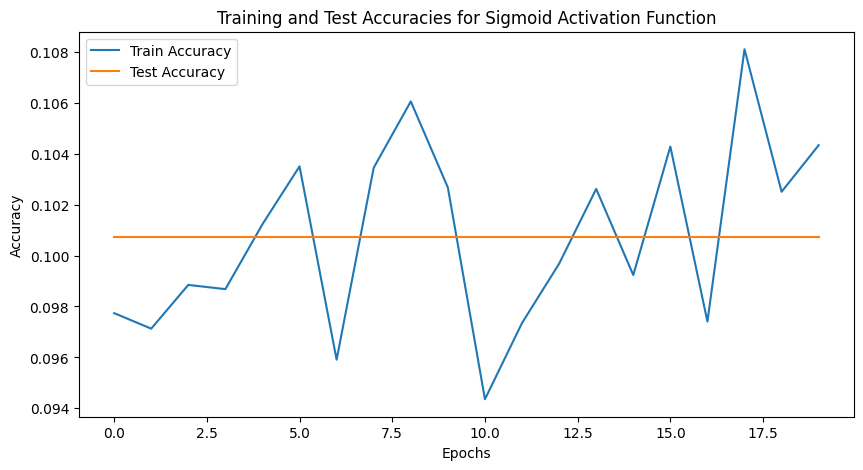

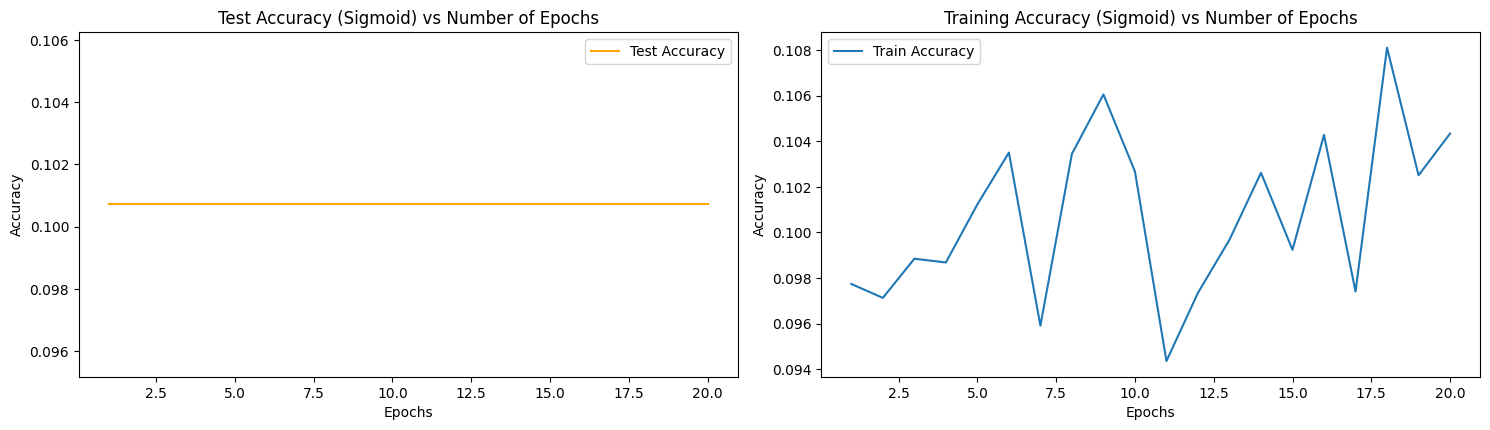

In [15]:
modelSigmoid = VGG11Sigmoid().to(device)
sigmoid_test_accuracies, sigmoid_train_accuracies, _, _ = train_and_evaluate(model=modelSigmoid, criterion=criterion, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs)

print(f"Train accuracy - Sigmoid: {sigmoid_train_accuracies}")
print(f"Test accuracy - Sigmoid: {sigmoid_test_accuracies}")

# Plotting training and test accuracies for both optimizers
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), sigmoid_train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), sigmoid_test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies for Sigmoid Activation Function')
plt.legend()
plt.show()
plt.figure(figsize=(15, 8))

# (a) Test Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, sigmoid_test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy (Sigmoid) vs Number of Epochs')
plt.legend()

# (b) Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, sigmoid_train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy (Sigmoid) vs Number of Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Exercise 1.7 Remove Dropout

In [16]:
# Define the VGG11 model
class VGG11_dropout(nn.Module):
    def __init__(self):
        super(VGG11_dropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Epoch [1/20], Train Loss: 2.3114, Train Acc: 0.1008, Test Loss: 2.3105, Test Acc: 0.1041
Epoch [2/20], Train Loss: 2.3106, Train Acc: 0.1018, Test Loss: 2.3104, Test Acc: 0.1045
Epoch [3/20], Train Loss: 2.3112, Train Acc: 0.1002, Test Loss: 2.3107, Test Acc: 0.1043
Epoch [4/20], Train Loss: 2.3109, Train Acc: 0.1001, Test Loss: 2.3106, Test Acc: 0.1045
Epoch [5/20], Train Loss: 2.3109, Train Acc: 0.1013, Test Loss: 2.3105, Test Acc: 0.1043
Epoch [6/20], Train Loss: 2.3108, Train Acc: 0.1010, Test Loss: 2.3105, Test Acc: 0.1041
Epoch [7/20], Train Loss: 2.3111, Train Acc: 0.0999, Test Loss: 2.3105, Test Acc: 0.1045
Epoch [8/20], Train Loss: 2.3109, Train Acc: 0.1016, Test Loss: 2.3106, Test Acc: 0.1042
Epoch [9/20], Train Loss: 2.3111, Train Acc: 0.1016, Test Loss: 2.3105, Test Acc: 0.1047
Epoch [10/20], Train Loss: 2.3109, Train Acc: 0.1014, Test Loss: 2.3104, Test Acc: 0.1041
Epoch [11/20], Train Loss: 2.3112, Train Acc: 0.1015, Test Loss: 2.3108, Test Acc: 0.1044
Epoch [12/20], Trai

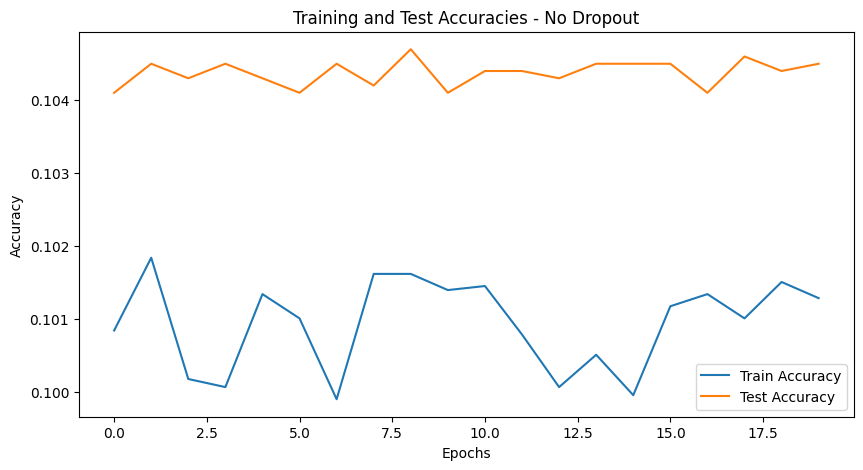

In [17]:
modelDropout = VGG11_dropout().to(device)
dropout_test_accuracies, dropout_train_accuracies, _, _ = train_and_evaluate(model=modelDropout, criterion=criterion, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs)

print(f"Train accuracy - Dropout: {dropout_train_accuracies}")
print(f"Test accuracy - Dropout: {dropout_test_accuracies}")

# Plotting training and test accuracies for both optimizers
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), dropout_train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), dropout_test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies - No Dropout')
plt.legend()
plt.show()